$\textbf{Sarsa$(\lambda)$ tailored for the reset application}$

The pseudo-code for Sarsa$(\lambda)$ tailored for the reset application can be found in Algorithm 3.

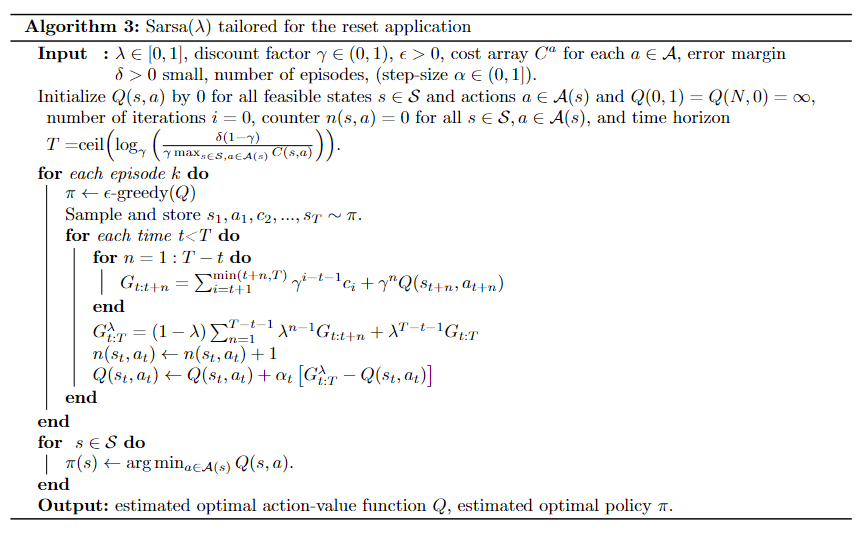

The implementation of this algorithm can be found in the code below.

In [1]:

import numpy as np
import time
import matplotlib.pyplot as plt



def SARSA_lambda(lam,alpha, gamma, epsilon,P,C_0,C_1, nrepisodes):
    # in case we want to use one of the four alpha depending on the iteration
    # alpha_type = 10: alpha = 1/log(t)
    # alpha_type = 20: alpha = 1/n_t(s)
    # alpha_type = 30: alpha = 1/t
    # alpha_type = 40: alpha = 1/log(n_t(s))
    alpha_type = alpha
    
    # in case we want to use one of the three epsilon depending on the episode/iteration 
    # epsilon_type = 2: epsilon = 1/min(episode nr, minimum nr of visits to state s)
    # epsilon_type = 3: epsilon = 1/(minimum nr of visits to state s)
    # epsilon_type = 4: epsilon = 1/(episode nr)
    epsilon_type = epsilon
    
    # size of the state space-1
    N=np.size(P,1)-1
    
    # state space S
    S=np.arange(N+1)
    
    # Q-values, here the rows correspond to the action and columns to the state
    # i.e., Q is of the form Q[s,a]
    Q=np.zeros([N+1,2])
    
    # setting the Q value for "illegal" actions to infinity
    Q[0,1]=float("inf")
    Q[N,0]=float("inf")
    
    # nr of iterations
    it=0
    
    # preselect time-horizon T
    delta=0.000001 # error margin
    C_0[N]=0 # setting cost "illegal" actions to zero
    C_1[0]=0 # setting cost "illegal" actions to zero
    C=np.array([C_0,C_1])   
    T=round(np.log((delta*(1-gamma))/(C.max()))/np.log(gamma)-1) # time-horizon T
    
    # initializing an array containing all states S_0,S_1,...,S_T
    states=np.zeros(T+1,dtype=int)
    
    # initializing an array containing all actions A_0,A_1,...,A_{T-1}
    actions=np.zeros(T+1,dtype=int)
    
    # initializing an array containing all rewarsd R_1,R_1,...,R_T
    rewards=np.zeros(T+1)
    
    # G(t,n)=G_{t:t+n}
    G = np.zeros([T+1,T+1])
    
    # G^\lambda_t 
    G_lambda = np.zeros(T+1)

    # Q[s,a,iteration number]: array to keep track of the Q-values per iteration
    Q_it=np.zeros([N+1,2,(nrepisodes)*T])
    
    # Q[s,a,episode number]: array to keep track of the Q-values per episode
    Q_ep=np.zeros([N+1,2,nrepisodes])
    
    # n_it[s,a] denotes the number of times (s,a) is visited at iteration it
    n_it=np.zeros([N+1,2])
    
    # keep track of the the optimal policy according to that episode
    policy_it=np.zeros([N+1,nrepisodes])
 
    # loop for each episode
    for e in range(1,nrepisodes+1):
        
        # randomly selecting and storing initial state
        states[0] =  np.random.randint(0, N+1)
        
        # randomly selecting and storing initial action
        #actions[0] =  0 # this should come from the policy => needs to be changed
        p=np.random.random() # sampling a p in [0,1)
        

        # selecting the epsilon, in case we want a episode/iteration dependent epsilon
        if epsilon_type==2:
        # epsilon = 1/min(episode nr, minimum nr of visits to state s)
           epsilon=1/min(e,max(1,min(n_it[states[0],:])))
        elif epsilon_type==3:
        # epsilon = 1/(minimum nr of visits to state s)
           epsilon=1/max(1,min(n_it[states[0],:]))
        elif epsilon_type==4:
        # epsilon = 1/episode nr
           epsilon = 1/e
        
        # with probability eps: random policy
        if p<epsilon: 
            actions[0] = np.random.randint(0, 2) 
        # with probability 1-eps: greedy policy
        else: 
            # note that np.argmin(Q[state,:]) will return action 0 if there is a tie,
            # thus we make sure in the case of a tie the action is chosen randomly.
            actions[0] = np.random.choice(np.flatnonzero(Q[states[0],:] == Q[states[0],:].min()))
        
        # making sure the chosen action is allowed for the state
        if states[0]==0:
            actions[0]=0 
        elif states[0]==N:
            actions[0]=1
            
        # loop for t=0,1,...,T-1
        for t in range(T): # when i do it like this it stays stuck in the first episode..
               
            # taking action A_t 
            # observing and storing the next reward as R_{t+1}
            # and sampling the next state S_{t+1} according to P  
            if actions[t]==1:
                states[(t+1)] = 0
                rewards[(t+1)] = C_1[states[t]] 
            elif actions[t]==0:
                states[(t+1)] = np.random.choice(S,p=P[states[t],:])
                rewards[(t+1)] = C_0[states[t]]
            
     
            # select and store an action A_{t+1} ~ pi(.|S_{t+1}) = eps-greedy policy
            # epsilon-greedy policy:
            p=np.random.random() # sampling a p in [0,1)
            
            # epsilon = 1/min(episode nr, minimum nr of visits to state s)
            epsilon=1/min(e,max(1,min(n_it[states[t+1],:])))
            # selecting the epsilon, in case we want a episode/iteration dependent epsilon
            if epsilon_type==2:
            # epsilon = 1/min(episode nr, minimum nr of visits to state s)
               epsilon=1/min(e,max(1,min(n_it[states[t+1],:])))
            elif epsilon_type==3:
            # epsilon = 1/(minimum nr of visits to state s)
               epsilon=1/max(1,min(n_it[states[t+1],:]))
            elif epsilon_type==4:
            # epsilon = 1/episode nr
               epsilon = 1/e
            
            # with probability eps: random policy
            if p<epsilon: 
                actions[(t+1)] = np.random.randint(0, 2) 
            # with probability 1-eps: greedy policy
            else: 
                # note that np.argmin(Q[state,:]) will return action 0 if there is a tie,
                # thus we make sure in the case of a tie the action is chosen randomly.
                actions[t+1] = np.random.choice(np.flatnonzero(Q[states[t+1],:] == Q[states[t+1],:].min()))
                   
        
            # making sure the chosen action is allowed for the state
            if states[t+1]==0:
                actions[t+1]=0 
            elif states[t+1]==N:
                actions[t+1]=1
            
        
        for t in range(T): 
            for n in range(1,T-t+1):

                # SARSA:
                G[t,n] =  np.sum([gamma**(i-t-1)*rewards[i] for i in range(t+1, min(t+n, T)+1)])+(gamma**n)*Q[states[(t+n)],actions[(t+n)]]

            
            # computing G^\lambda_t
            G_lambda[t] = (1-lam)*np.sum([lam**(n-1)*G[t,n] for n in range(1, T-t)]) + lam**(T-t-1)*G[t,T-t]
            
            # incrementing the nr of visits to (s,a) by 1  
            n_it[states[t],actions[t]]+=1 
            

            # in case we want to use an alpha depending on the iteration nr:
            if alpha_type == 10:
                alpha=1/np.log(it+3)  # +3 to make sure alpha<=1
                
            if alpha_type == 40:
                alpha=1/np.log(n_it[states[t],actions[t]]+2)
            
            if alpha_type == 20:
                alpha=1/n_it[states[t],actions[t]]
                
            if alpha_type == 30:
                alpha=1/(it+1)
            
            # updating the Q-value
            Q[states[t],actions[t]]+=alpha*(G_lambda[t] - Q[states[t],actions[t]])
            
            # storing the Q(s,a)-update per iteration
            Q_it[states[t],actions[t],it] = Q[states[t],actions[t]]
            
            # increment the number of iterations by 1
            it+=1   
        
        # keeping track of the (updated) policy and Q-values and policy for the current episode
        policy_it[:,e-1] = np.argmin(Q,axis=1) 
        Q_ep[:,0,e-1] = Q[:,0]
        Q_ep[:,1,e-1] = Q[:,1]
          
    # the optimal policy and optimal value       
    policy = np.argmin(Q,axis=1)    
    value = np.min(Q,axis=1)    
    
    return Q, it, T, Q_it, states, actions, rewards, G, G_lambda, policy, policy_it, Q_ep, value



Initializing the algorithm's parameters:

In [2]:
# discount factor
gamma=0.3

# epsilon in epsilon-greedy:
     # in case we want to use one of the three epsilon depending
     # epsilon_type = 2: epsilon = 1/min(episode nr, minimum nr of visits to state s)
     # epsilon_type = 3: epsilon = 1/(minimum nr of visits to state s)
     # epsilon_type = 4: epsilon = 1/(episode nr)    
epsilon=2

# step-size alpha:
    # in case we want to use one of the four alpha depending on the iteration
    # alpha_type = 10: alpha = 1/log(t)
    # alpha_type = 20: alpha = 1/n_t(s)
    # alpha_type = 30: alpha = 1/t
    # alpha_type = 40: alpha = 1/log(n_t(s))
alpha=20


# nr of episodes
nrepisodes = 2000

# number of states - 1
N=3

# lambda
lam=0.5

Initializing the probability transition matrix (choose one of the three):

In [ ]:
# P_A
P = np.diag(np.ones(N),1)
P[N,0]=1


In [3]:
# P_B
P = np.diag(1/2*np.ones(N),1)+np.diag(1/2*np.ones(N),-1)
P[-1,-2]=1
P[0,1]=1


In [ ]:
# P_C
P = 1/4*np.ones([N+1,N+1])


Initializing the cost realization (choose one of the three):

In [4]:
# Realization 1

# Cost for action = 0
C_0=np.zeros(N+1)

# Cost for action = 1
C_1=np.arange(N+1,dtype=float)
C_1[N]=2*N


In [ ]:
# Realization 2

# Cost for action = 0
C_0=np.arange(N+1,dtype=float)+1 

# Cost for action = 1
K=2
C_1=K*C_0


In [ ]:
# Realization 3

# Cost for action = 0
C_0=1/np.arange(N+1,0,-1,dtype=float)

# Cost for action = 1
C_1=10**np.arange(N+1,dtype=float)


$\textit{Example}:$ cost realization 1 with transition matrix $\mathcal{P}_B$ for $\lambda=0.5$, $\gamma=0.3$, and $N=3$.

In [5]:
Q, it, T, Q_it, states, actions, rewards, G, G_lambda, policy, policy_it, Q_ep, value = SARSA_lambda(lam,alpha, gamma, epsilon,P,C_0,C_1, nrepisodes)


print("Q-value: \n",Q)
print("Optimal policy: \n",policy)
print("Optimal value: \n",value)

Q-value: 
 [[0.04791767        inf]
 [0.15209188 1.01830645]
 [0.94921588 2.01612392]
 [       inf 6.01480546]]
Optimal policy: 
 [0 0 0 1]
Optimal value: 
 [0.04791767 0.15209188 0.94921588 6.01480546]
